In [1]:
# import setGPU

import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
import tensorflow as tf
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.layers.advanced_activations import PReLU, LeakyReLU
from sklearn.utils import shuffle
import h5py

import getpass
import json

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Anomalous"]



Using TensorFlow backend.


In [2]:
#Authenticate in order to get permission for eos
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [16]:
#Read history

name = "group0_autoencoder1"
loss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_loss.npy' % name)
valloss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_valloss.npy' % name)
testloss = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/%s_testloss.npy' % name)

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


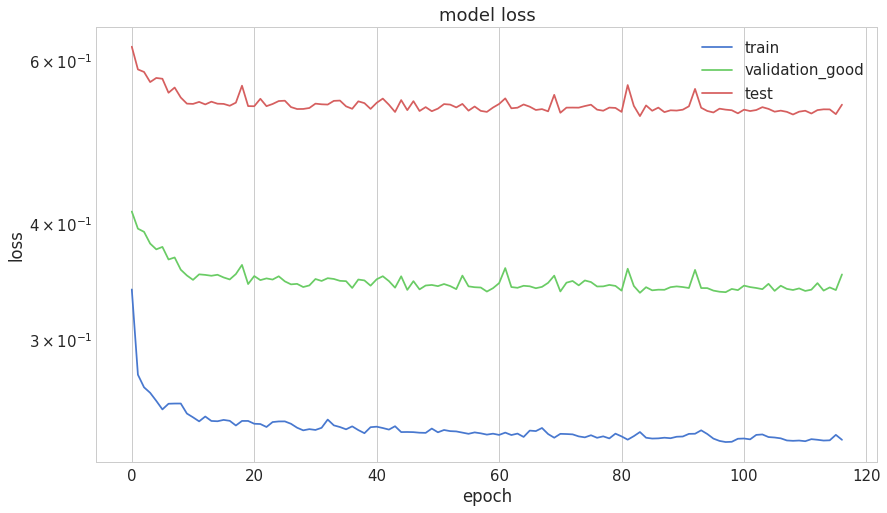

In [17]:
#Visualize history

f = plt.figure()
plt.plot(loss)
plt.yscale('log')
plt.plot(valloss)
plt.title('model loss')
plt.plot(testloss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation_good', 'test' ], loc='upper right')


In [25]:
#Load files
#history = np.load('/eos/cms/store/user/fsiroky/ae_models/%s.npy' % name)
# autoencoder = load_model("/afs/cern.ch/user/f/fsiroky/models_ae/%s.h5" % name)
autoencoder = load_model("/afs/cern.ch/user/f/fsiroky/public/dec_model.h5")


#CHANGE PATHS TO: /afs/cern.ch/user/f/fsiroky/models_ae/data_eval

X_test = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/X_testfor3pds_model.npy')
y_test = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/y_testfor3pds_model.npy')
last_train_idx = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/last_train_idx.npy')
lumisections = np.load('/afs/cern.ch/user/f/fsiroky/models_ae/data_eval/lumisections.npy')
lumisections = pd.DataFrame(lumisections)

In [26]:
#Show model architecture
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2810)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2811000   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2810)              2812810   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 2810)              0         
Total params: 5,623,810
Trainable params: 5,623,810
Non-trainable params: 0
_________________________________________________________________


In [27]:
#Make prediction
predictions = autoencoder.predict(X_test)

In [28]:
#Take mean of 500 worst reconstructed features
temp = np.partition(-np.power(X_test - predictions, 2), 500)
result = -temp[:,:500]


mse = np.mean(result, axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse,
                         'true_class': y_test})


/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


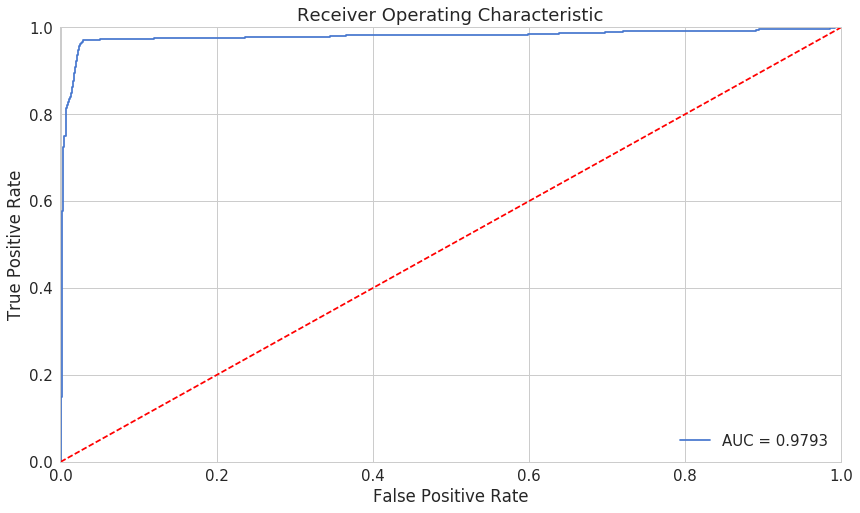

In [29]:
#Make ROC_curve
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# plt.savefig("jetC_MinMaxScaler_e350_bs1000_ed14_ROC.pdf")

In [30]:
threshold = 42

/usr/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


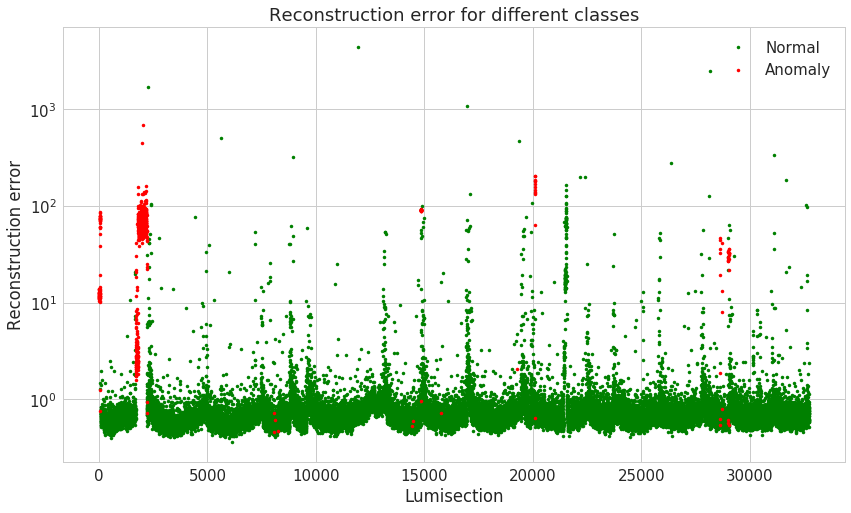

In [31]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 0:
        print()
#         print('Actually good lumis with reconstruction error higher than', threshold)
    elif name ==1:
        print()
#         print('Actually anomalous lumis with reconstruction error higher than', threshold)
#     print(group['reconstruction_error'][group['reconstruction_error']<threshold])
    ax.plot(group.index, group.reconstruction_error, color="red" if name == 1 else "green", marker='o', ms=3.5, linestyle='',
            label= "Anomaly" if name == 1 else "Normal")
#ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
ax.set_yscale('log')
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Lumisection")
plt.show()